$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$


# CS236781: Deep Learning
# Tutorial 12: Multimodal

## Introduction

In this tutorial, we will cover:

- What is multimodality
- Main challanges
- CLIP
    - zero shot classification 
    - prompt tuning
    - interpertability

In [83]:
# Setup
%matplotlib inline
import os
import sys
import torch
import torchvision
import matplotlib.pyplot as plt

In [84]:
plt.rcParams['font.size'] = 20
data_dir = os.path.expanduser('~/.pytorch-datasets')

# Modality

Modality refers to the way in which something expressed or perceived.

<center><img src="modals.png" width=7000 /></center>




# Multi-modality
---
### Multimodal is the scientific study of *heterogeneous*(1) and *interconnected*(2) data

### Heterogeneity

1. Element representations: Discrete, continuous, granularity

<center><img src="table.png" width=1000 /></center>

2. Element distributions: Density, frequency

3. Structure: Temporal, spatial, latent, explicit

4. Information: Abstraction, entropy (do i see if the room is clean, a clean couch indicade a clean room?)

5. Noise

6. Relevance: Task, context dependence(?)


<img src="gay.jpeg" width=300 />


### Connected Modalities

Shared information related modalities.

* Statistical: it can be association (co-accurrence ) or dependent (causal)

* Semantical: correspondance (laptop) or relational (a is used for b)


## Callanges
---

### Representation

Learning representations that reflect cross-modal interactions between individual elements, across different modalities.

<img src="rep.png" width=700 />


### Alignment

Identifying and modeling cross-modal connections between all elements of multiple modalities, building from the data structure

* An expamle: Object detection (yes, boundix boxes can be viewed as modality!)

* a hard challange in sequancial data like NLP and Video

### Reasoning

Combining knowledge, usually through multiple inferential steps, exploiting multimodal alignment and problem structure.

* create a graph that describe a scene using a quary in text + image
<img src="gal.png" width=700 />
from TranstextNet: by Kenigsfield et al

### Generation

Learning a generative process to produce raw modalities that reflects cross-modal interactions, structure and coherence.

* As you learned in the lecture about diffusion models

### Transference


Transfer knowledge between modalities, usually to help the target modality which may be noisy or with limited resources.

* High resolution images using pointcloud/radar/text

# CLIP: Learning Transferable Visual Models From Natural Language Supervision

* CLIP is a seminal work by OpenAI that very simply alighn images and text representations by cosine similarity loss for each batch.

* It aplications vary from completly changing interpertability of deep learning models, to revolution in zero-shot classification, and openinig new frontier in research.

* The idea can be extended to learn uniform representation for other modalities, and even more then two.

<img src="clip.png" width=1500 />


In [85]:
# Install CLIP in the tutorial env
#! pip install ftfy regex tqdm|
#! pip install git+https://github.com/openai/CLIP.git

In [86]:
import numpy as np
import torch

## Loading the model

``clip.available_models()`` will list the names of available CLIP models.



We can replace them with... More convolutions, of course

In [87]:

import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [88]:
model, preprocess = clip.load("ViT-B/32")
model.eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


Lets look at the image and text preprocess

In [89]:
print(preprocess)

print(clip.tokenize("Hello World!"))

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x31819cf70>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)
tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)


### Setting up input images and texts


In [90]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse", 
    "coffee": "a cup of coffee on a saucer"
}

In [91]:
from skimage import data
data.data_dir

'/Users/moshekimhi/Library/Caches/scikit-image/0.21.0/data'

In [ ]:
original_images = []
images = []
texts = []
plt.figure(figsize=(25, 7))

path = '/Users/moshekimhi/miniconda3/envs/cs236781/lib/python3.8/site-packages/skimage/data'

for filename in [filename for filename in os.listdir(path) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(path, filename)).convert("RGB")
  
    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()

### Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.


In [93]:
image_input = torch.tensor(np.stack(images))
text_tokens = clip.tokenize(["This is " + desc for desc in texts])

with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

###  Cosine similarity


Denote Image features of the i-th image by by $I_i$ and text features of the i-th text by $T_i$,

The Cosine similarity define as the cosine of the angel between the two vectors:
$$
Cos(\theta) = \frac{I_i \bullet T_i}{||I_i|| ||T_i||}
$$

If we can enforce with optimization that the cosine is small for text that describe each image, the representations of both will be similar, and thus we can use it to search in the text space for the image and vise-versa! 

The loss of CLIP is ridiculusly simple, just calculate cosine similarity of all paits and enforce the identity matrix.

In [94]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

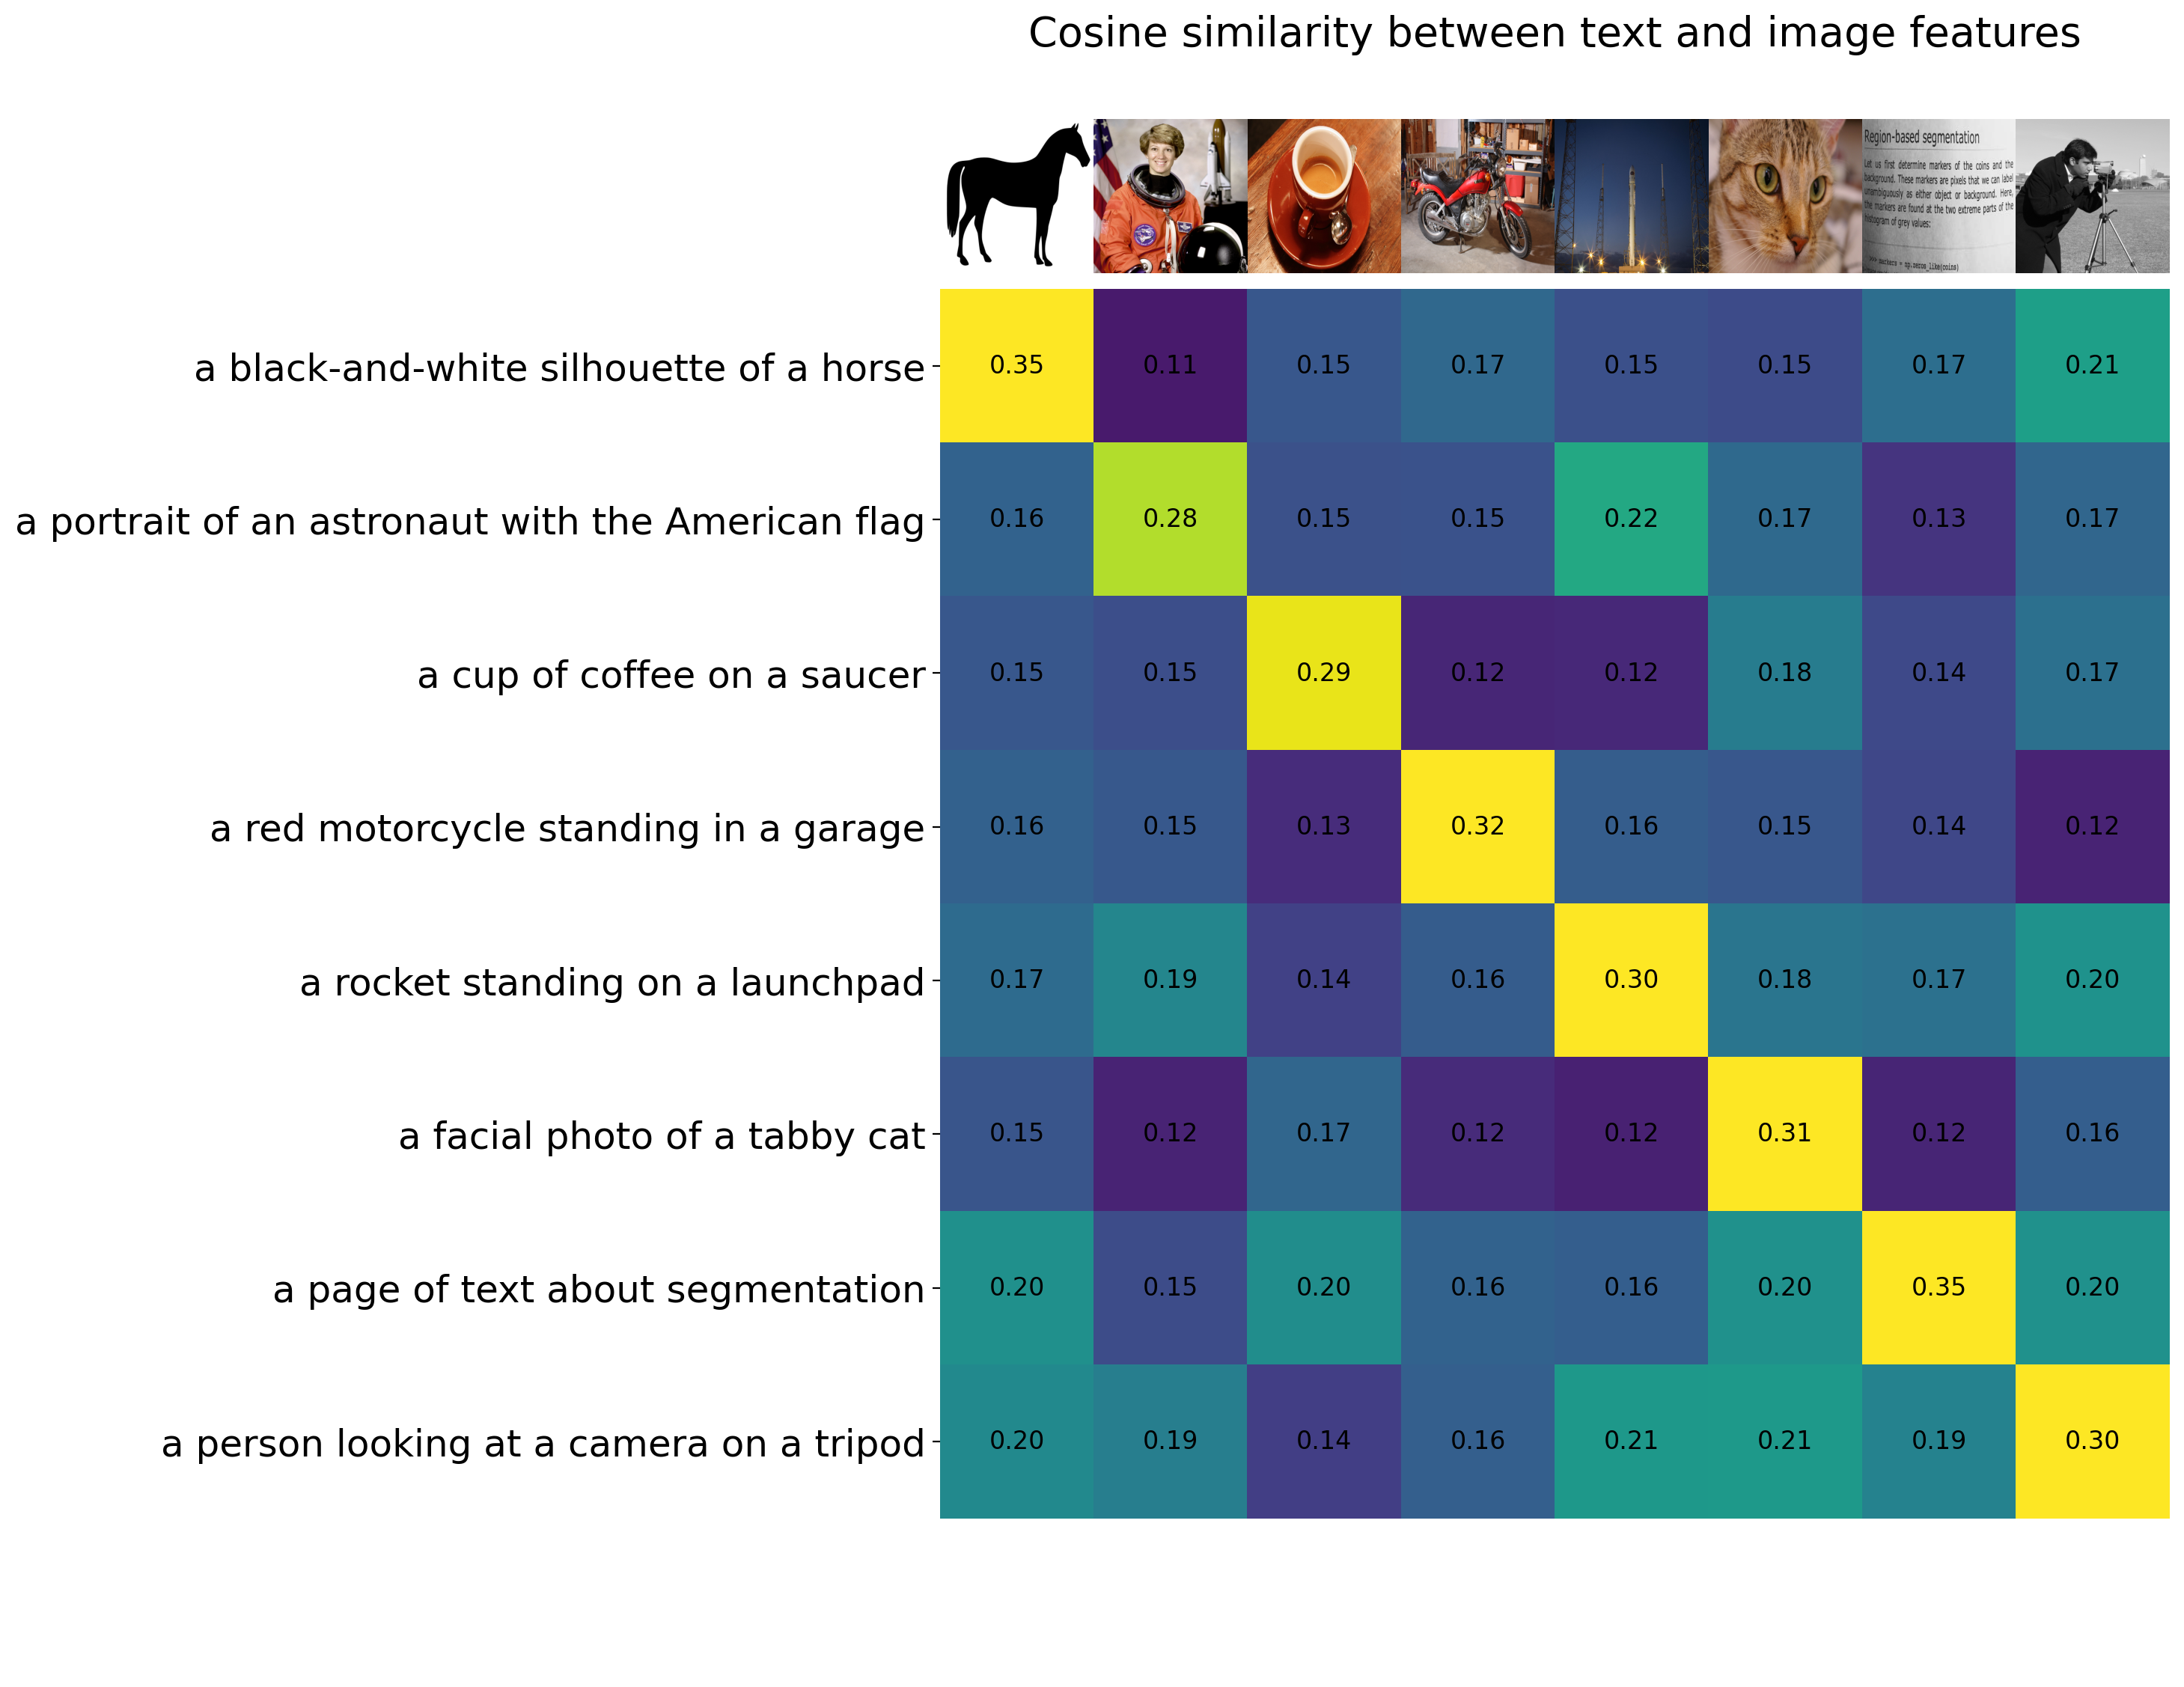

In [95]:

count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

## Zero-Shot Image Classification


You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.



In [96]:
from torchvision.datasets import CIFAR100
cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

Files already downloaded and verified


In [97]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions)

In [98]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

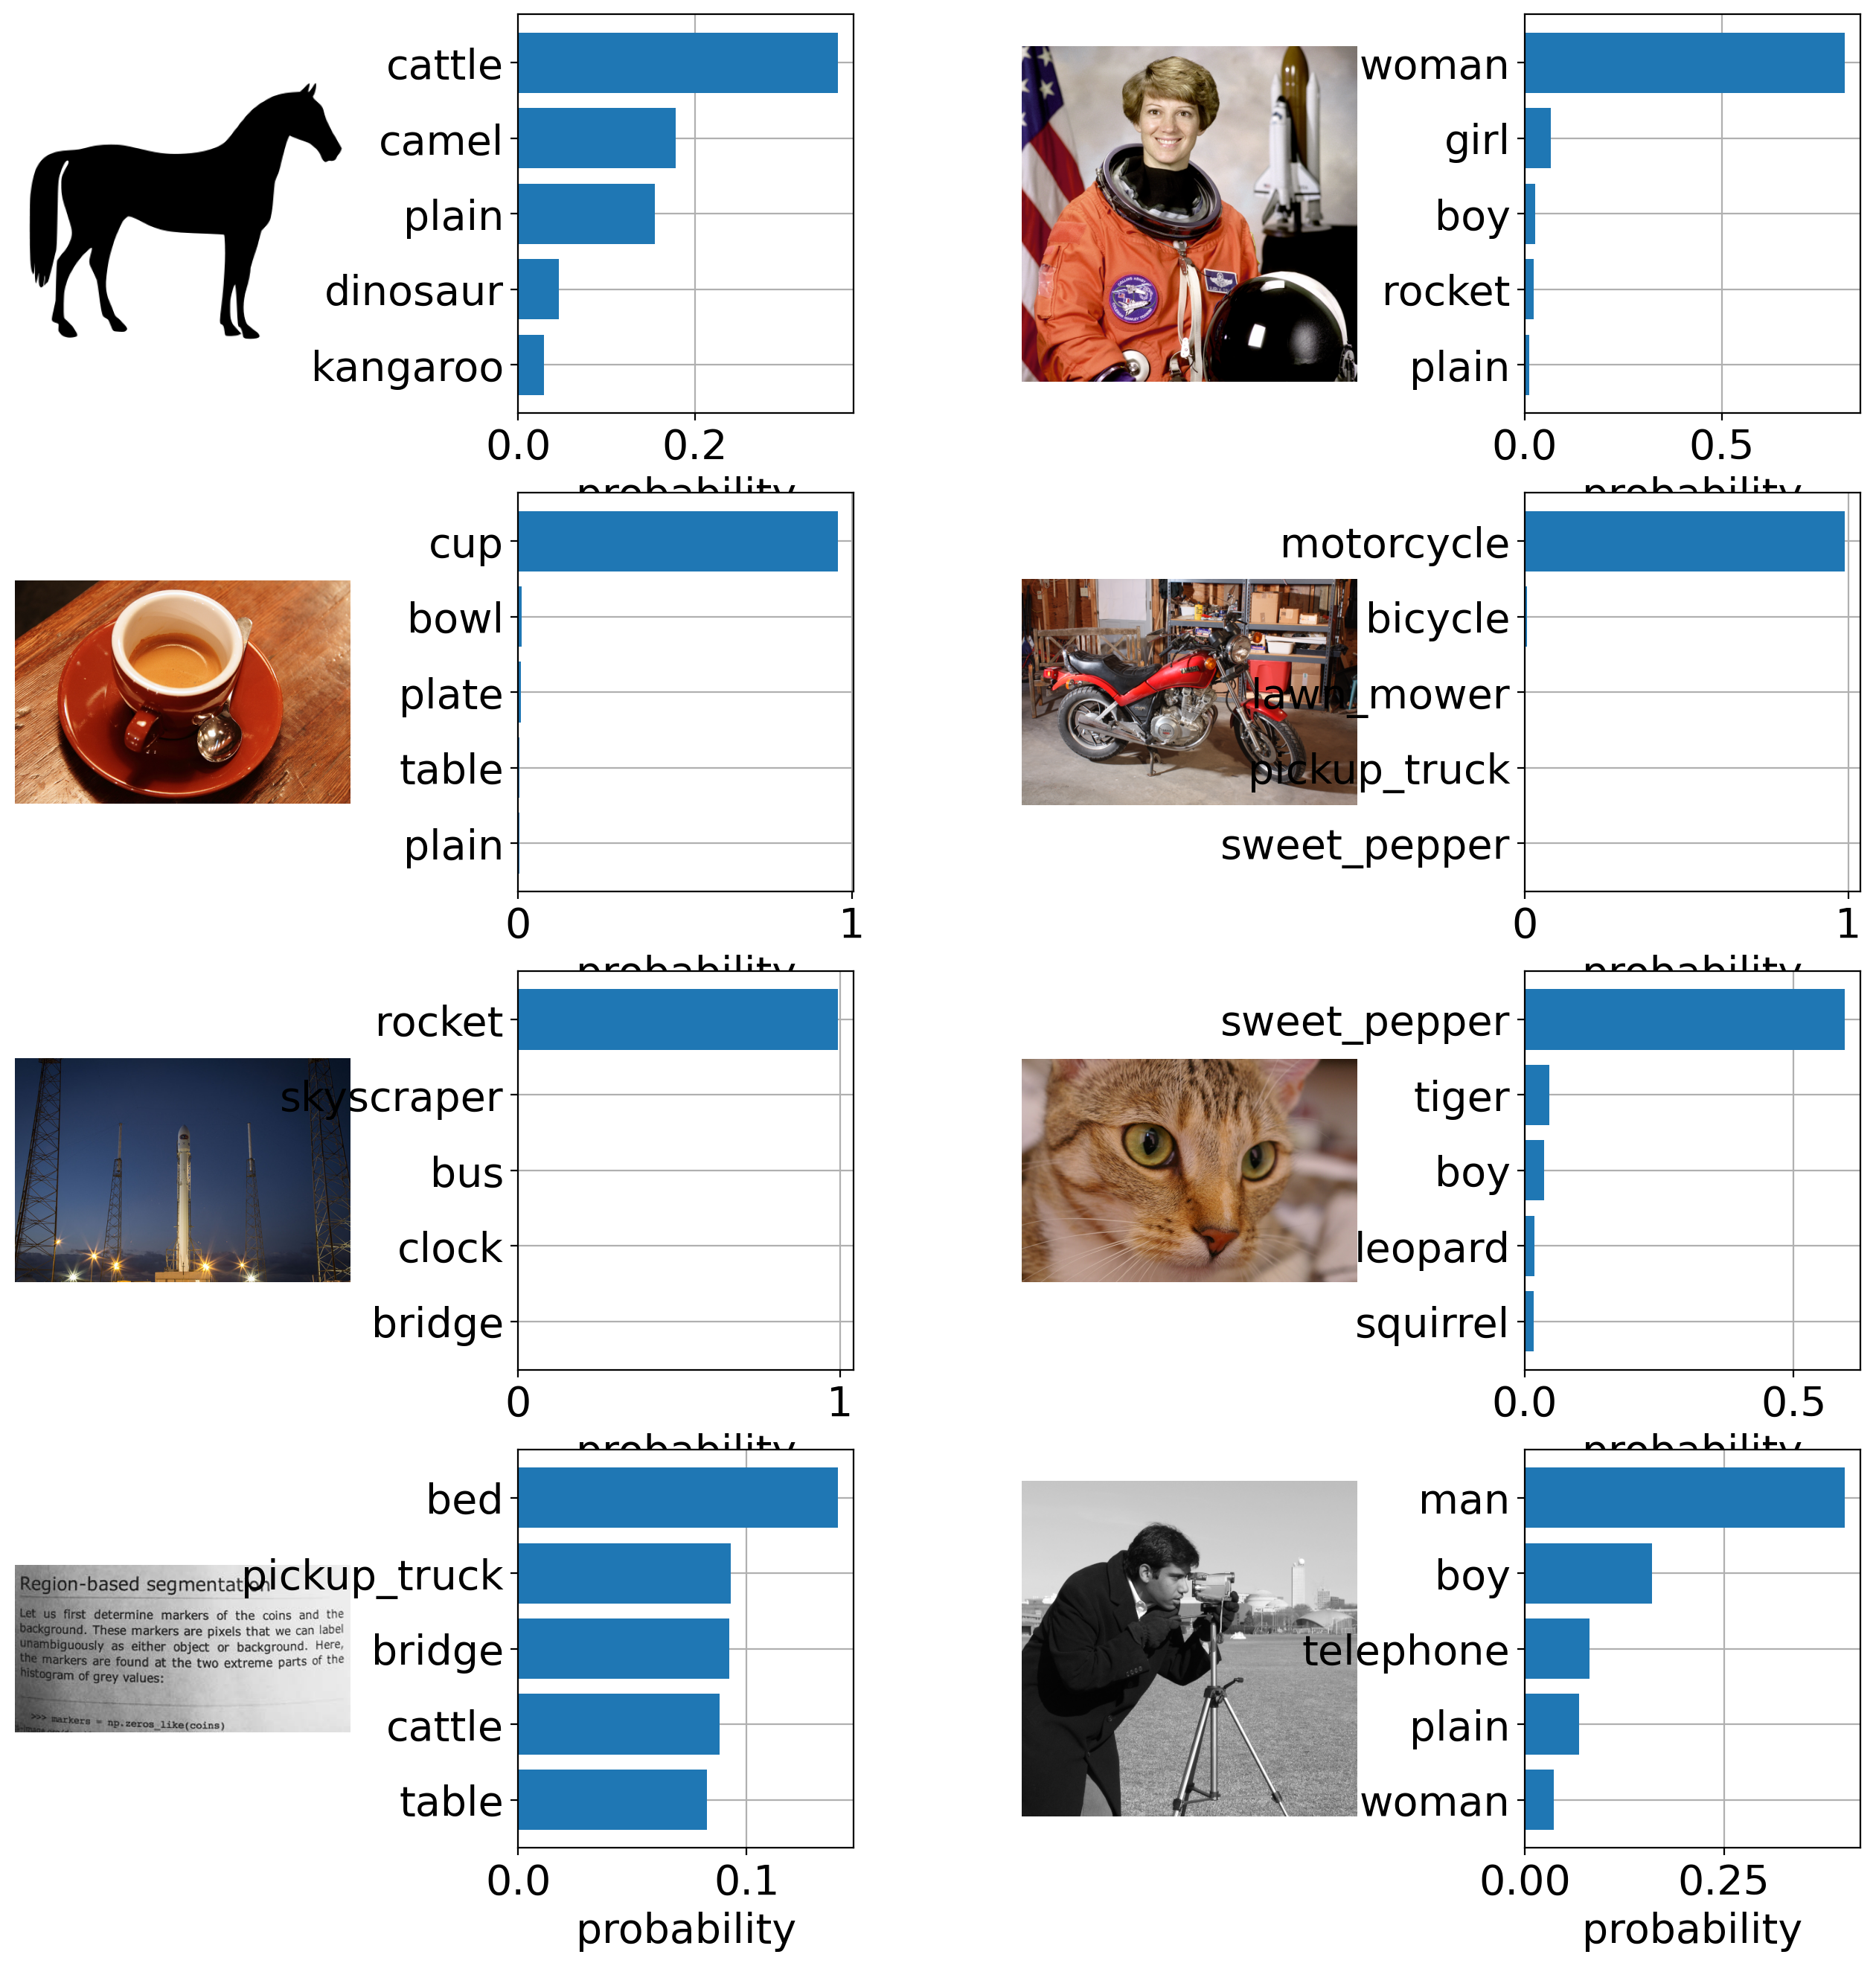

In [99]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

### Prompt engneering is important here
---

what if we just use the label, without "this is an image of"?

We can get better accuracy, or better confidance using other prompts, but we can also get interpertablity using diffrent prompts.

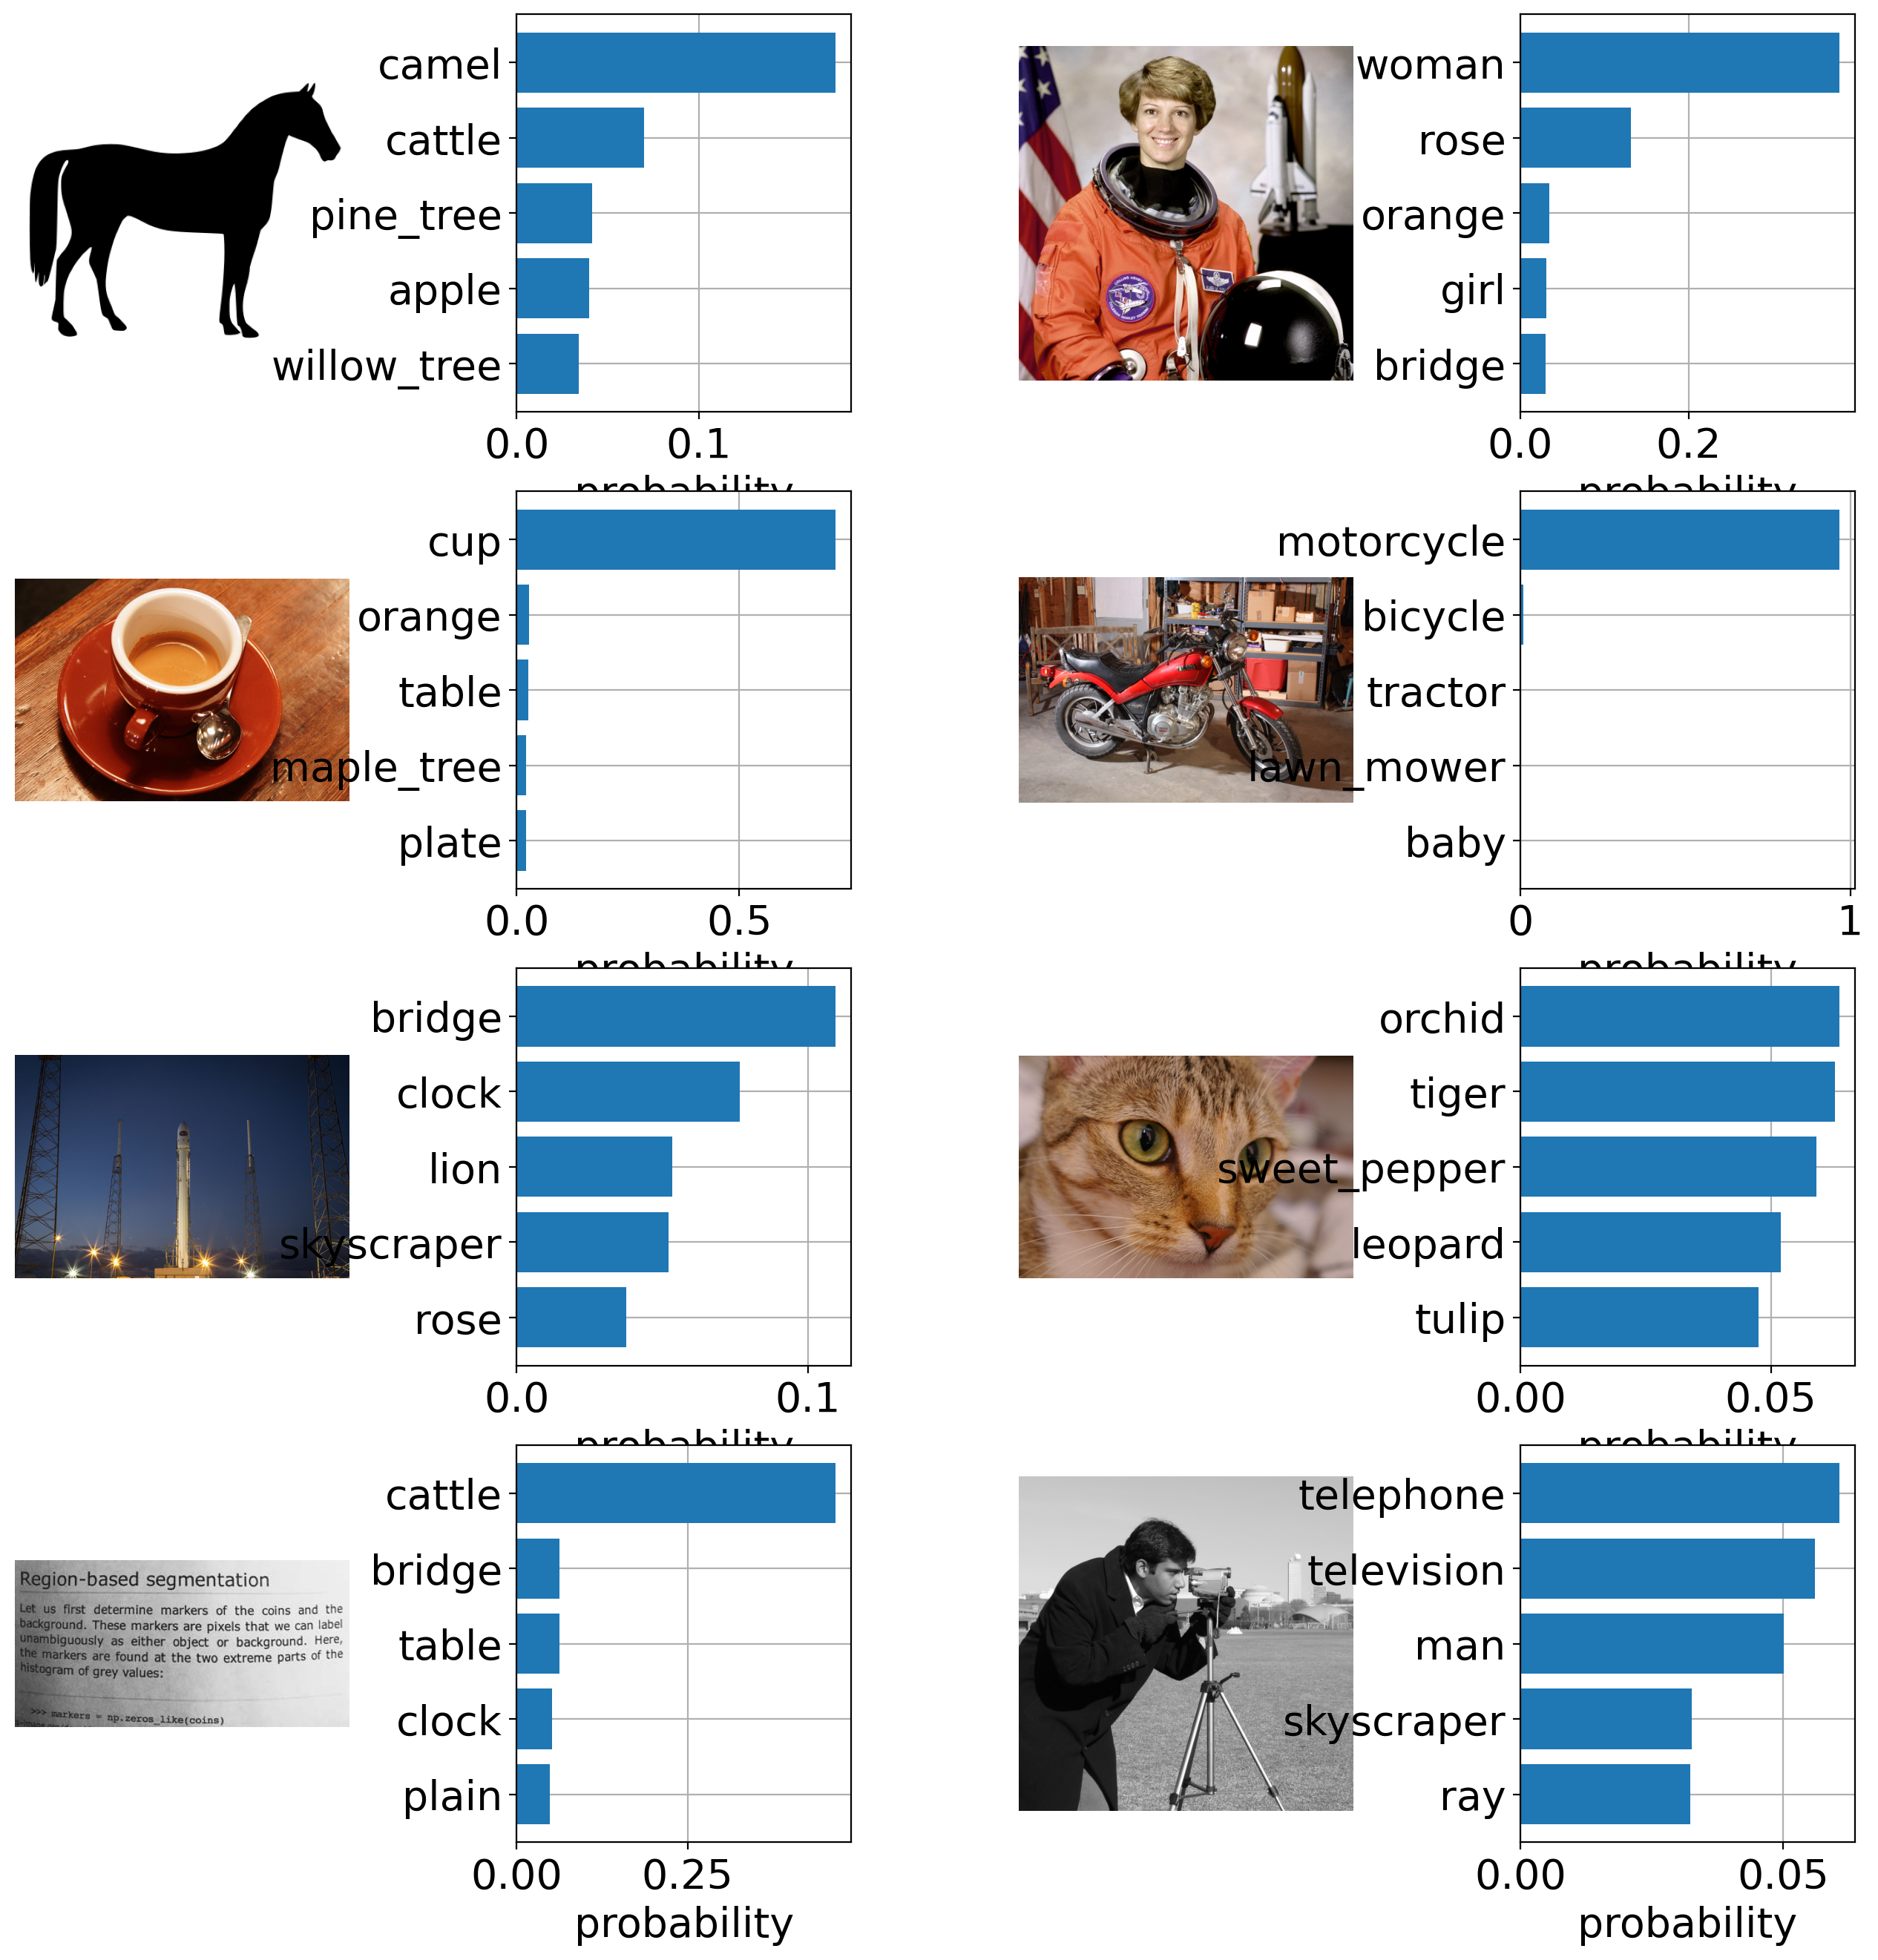

In [100]:
text_descriptions = [f"This is {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions)

with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

* We can also try to learn concepts and hence create interpertability

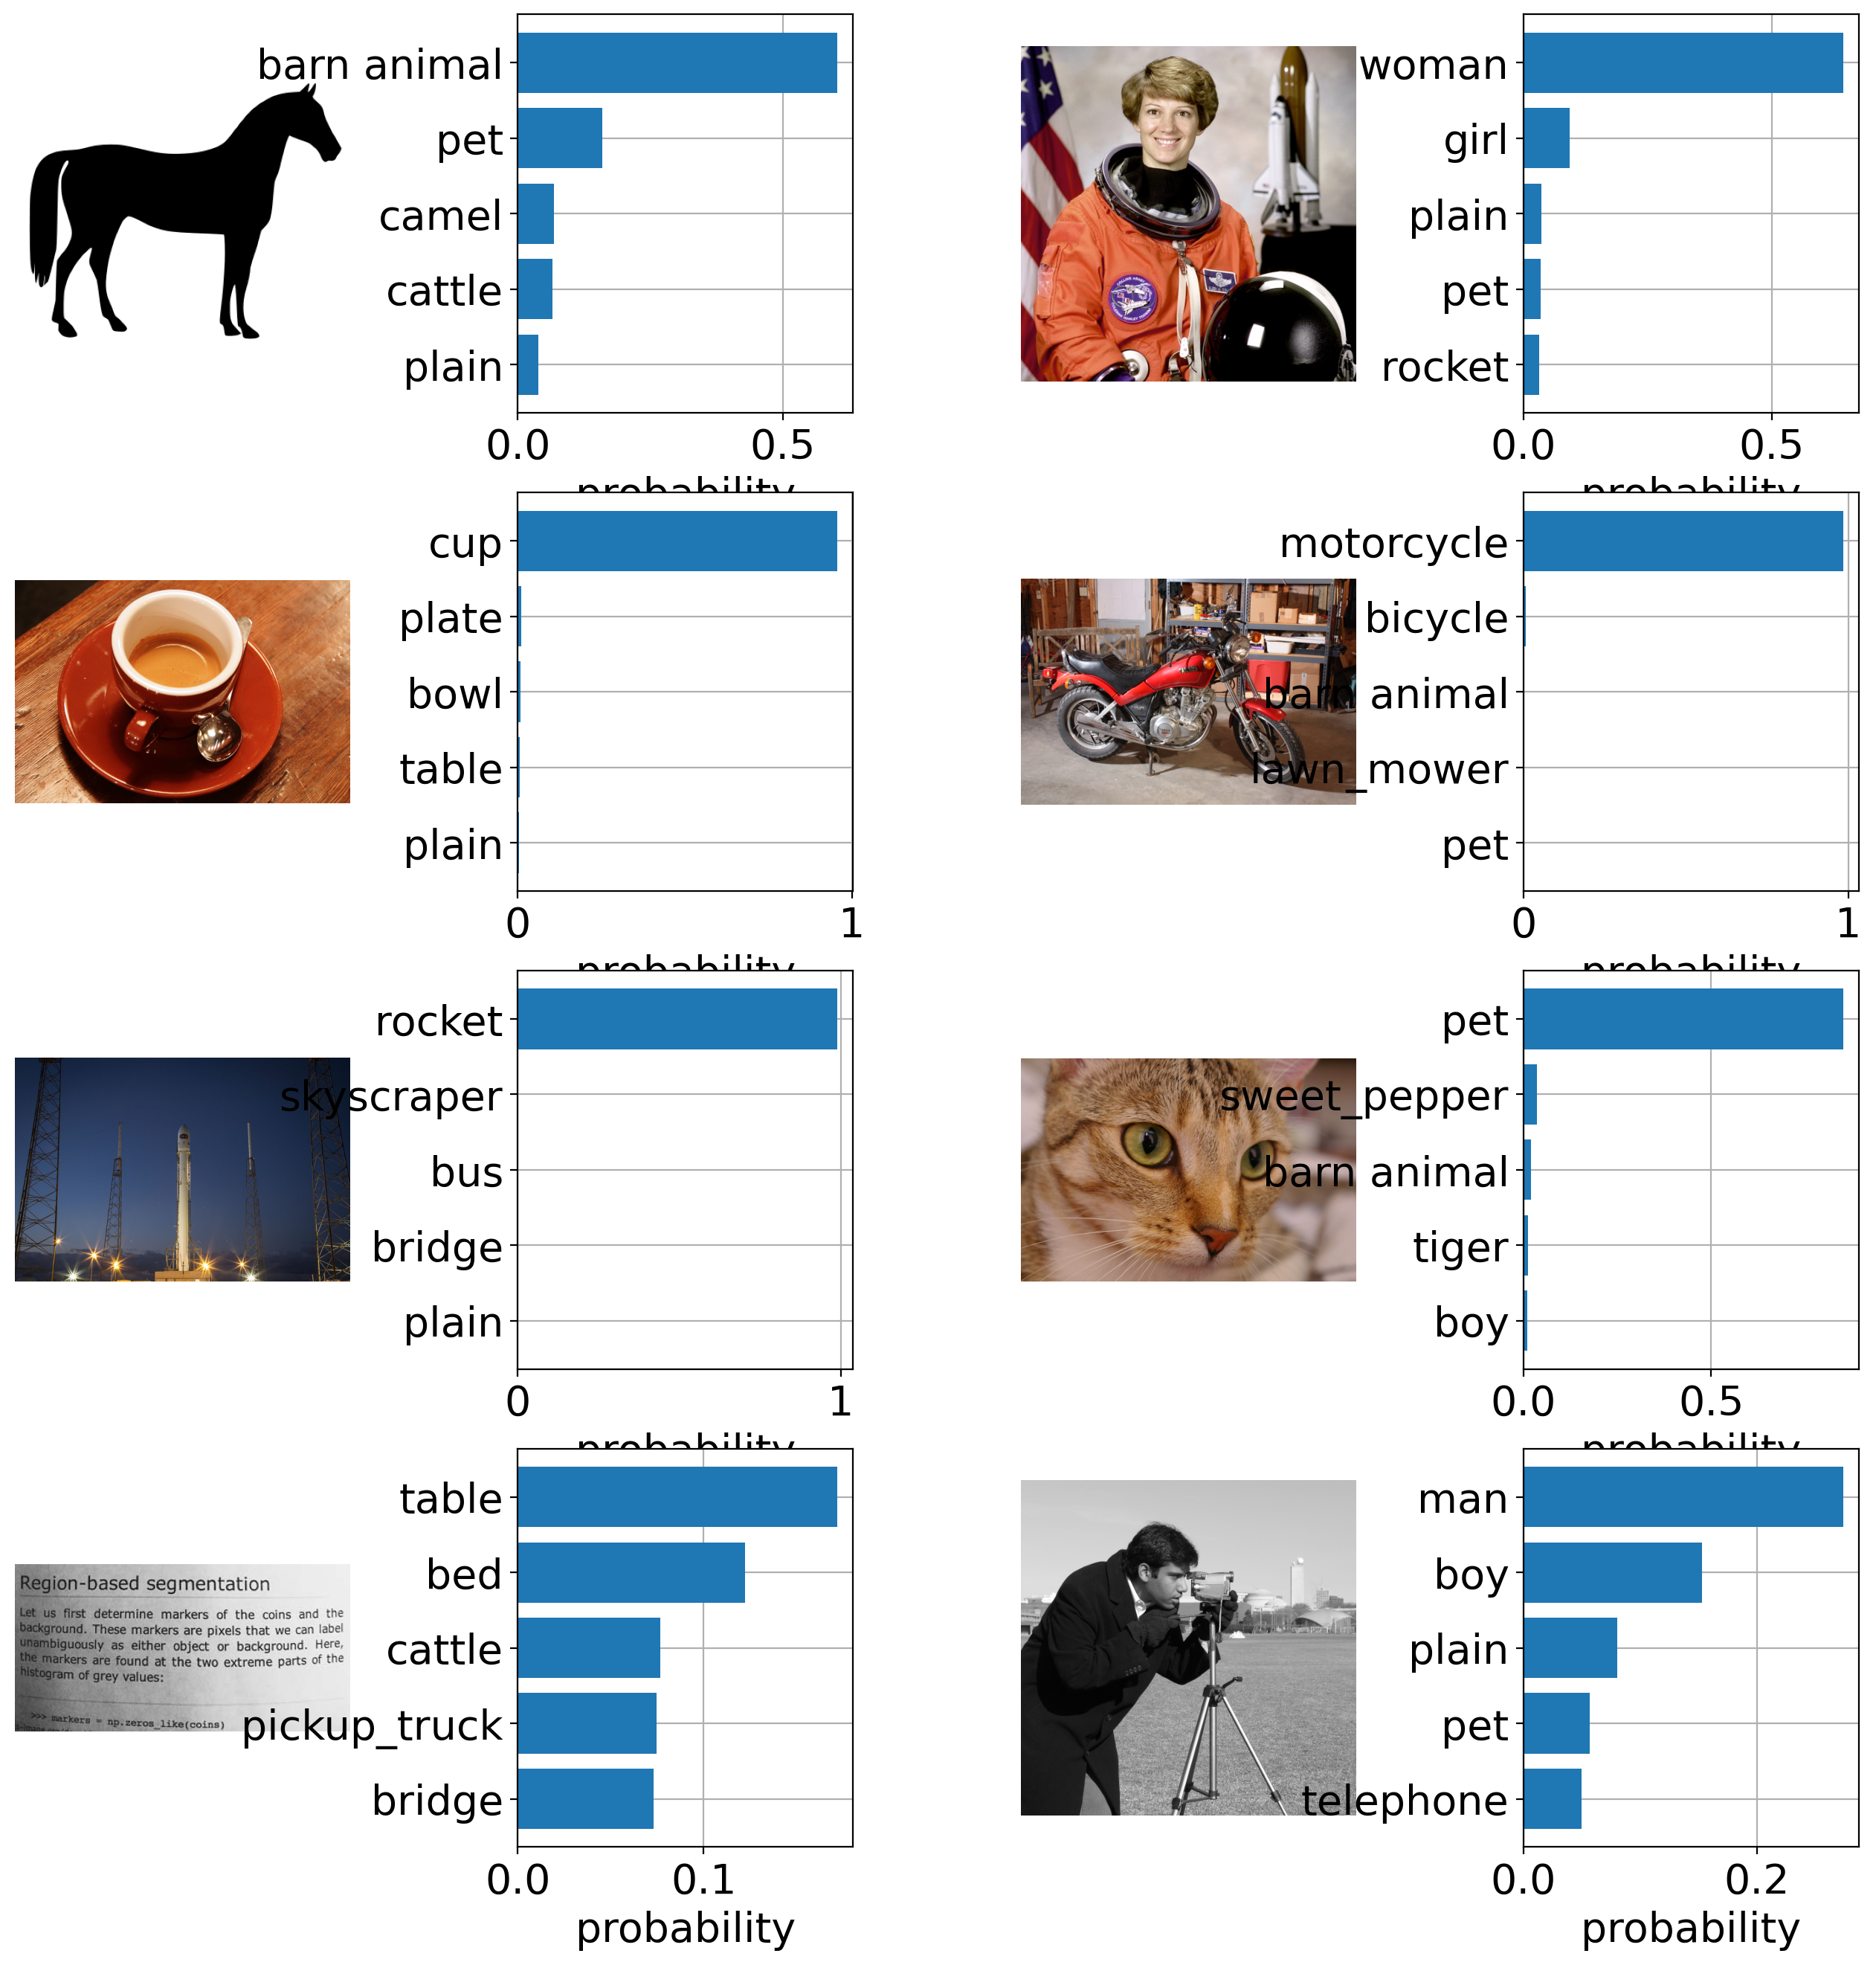

In [102]:
text_descriptions = [f"This is an image of a {label}" for label in cifar100.classes]
text_descriptions[0] = "An image of a pet" #override apple
cifar100.classes[0] = "pet"
text_descriptions[1] = "An image of a barn animal" #override fish
cifar100.classes[1] = "barn animal"


text_tokens = clip.tokenize(text_descriptions)

with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

#### Thanks!

**Credits**

This tutorial was written by [Moshe Kimhi](https://mkimhi.github.io/).<br>
To re-use, please provide attribution and link to the original.

Some images in this tutorial were taken and/or adapted from the following sources:

- Clip code based on CLIP original tutorial by OpenAI https://github.com/openai/CLIP
- Carnegie Mellon University course on multimodal https://cmu-multicomp-lab.github.io/mmml-course/fall2020/